In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time 
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chandanshashwat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chandanshashwat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chandanshashwat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/chandanshashwat/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
os.getcwd()

'/Users/chandanshashwat/Desktop/NLP 21'

In [3]:
df_original = pd.read_csv("tweet_emotions.csv")

In [4]:
df = df_original.copy()

In [5]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [6]:
df.count()

tweet_id     40000
sentiment    40000
content      40000
dtype: int64

In [7]:
df.head(5)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [8]:
df = df.loc[:,['sentiment','content']]

In [9]:
df.head(2)

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...


In [10]:
df['sentiment'] = df['sentiment'].str.lower()

In [11]:
df.isnull().sum()

sentiment    0
content      0
dtype: int64

In [12]:
df.shape

(40000, 2)

/var/folders/hy/skgp6qs54hb_bmj9gj2tg20m0000gn/T/ipykernel_6688/3762433967.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


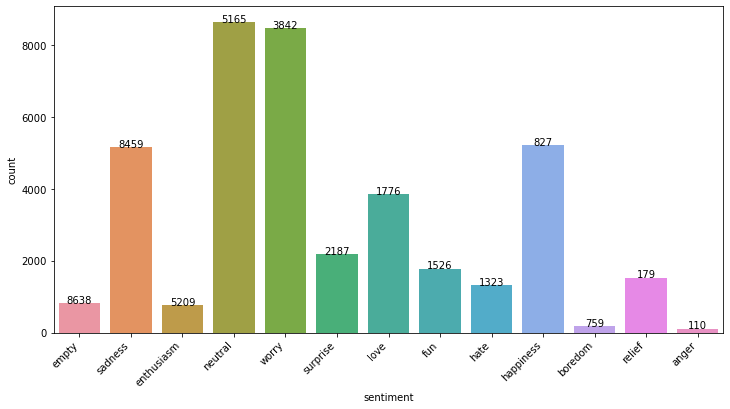

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax = sns.countplot(x='sentiment', data=df)
i=0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2, height + 0.1, df['sentiment'].value_counts()[i], ha='center')
    i+=1

In [14]:
#removing class if any has a value 1
df = df.groupby('sentiment').filter(lambda x : len(x)>1)

#removing stopwords
stop = stopwords.words('english')
df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#removing urls
df['content'] = df['content'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

#removing HTML Tags
def remove_tags(string):
    result = re.sub('<.*?>', '', string)
    return result
df['content'] = df['content'].apply(lambda cw : remove_tags(cw))

#removing '\n' in the code
df['content'] = df['content'].replace('\n', ' ', regex=True)

#removing punctuations
punctuation = '''!()-[]{};:'"\,<>/?@#$%^&*~'''
def remove_punctuations(text):
    for punc in punctuation:
        text = text.replace(punc, '')
    return text
df['content'] = df['content'].apply(remove_punctuations)

#removing digits
df['content'] = df['content'].str.replace('\d+', '')

/var/folders/hy/skgp6qs54hb_bmj9gj2tg20m0000gn/T/ipykernel_6688/905151715.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  df['content'] = df['content'].str.replace('\d+', '')


In [15]:
df.head(5)

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,Layin n bed headache ughhhh...waitin call...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants hang friends SOON
4,neutral,dannycastillo We want trade someone Houston ti...


In [16]:
#lemmitization
# from nltk.stem import WordNetLemmatizer
# from nltk import word_tokenize

WNlemma = nltk.WordNetLemmatizer()


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def pre_process_with_pos_tag(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if len(t)>2]
    tokens = [WNlemma.lemmatize(t, get_wordnet_pos(pos_tag(word_tokenize(t))[0][1])) for t in tokens]
    text_after_process = " ".join(tokens)
    return text_after_process

In [17]:
df['content'] = df['content'].apply(pre_process_with_pos_tag)

In [18]:
df.head(5)

,sentiment,content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin bed headache ughhhh ... waitin call ...
2,sadness,funeral ceremony ... gloomy friday ...
3,enthusiasm,want hang friend soon
4,neutral,dannycastillo want trade someone houston ticke...


In [19]:
#Analysing the words in the content column
results = set()
df['content'].str.lower().str.split().apply(results.update)
print(results)

{'doombug', 'anita', 'sparkly_devil', 'bexy', 'socal', 'silatjunkie', 'girlquot', 'charactres', 'hustle', 'hdd', 'seanthigpen', 'mopedronin', 'httpyfrog.comltrdaj', 'isang', 'superglued', 'shag', 'v_era', 'dslr', 'nonbeliever', 'monroejnicole', 'redi', 'kelcouch', 'hairspray', 'ecxept', 'selalu', 'salt', 'dummerboyk', 'exceededquot', 'tylarjay', 'malibu', 'sumthinnn', 'russia', 'papaw', 'comee', 'minday', 'wifi', 'lovee', 'luckkyy', 'saver', 'levitte', 'shotgun', 'quotwholey', 'puggy', 'o_o', 'andreaheartscgh', 'httptinyurl.comnlr', 'primaveron', 'alwaysmuah', 'www.myspace.comaiden', 'abzquine', 'roediger', 'vog', 'bebe', 'greenlake', 'goshy', 'styoopid', 'analog', 'coffeeee', 'ruin', 'bursting', 'laflour', 'pano', 'wita', 'davidmihm', 'floyd', 'hznkzm', 'httpwww.skgaming.commatch', 'bushing', 'dr_cranes', 'tinabby', 'fosforo', 'nau', 'heffer', 'httpmyloc.mesl', 'velvet', 'mzladi_b', 'claudiaintouch', 'meg', 'hoover', 'mtvawards', 'xjamiex', 'complexion', 'welcomeee', 'belong', 'imposi

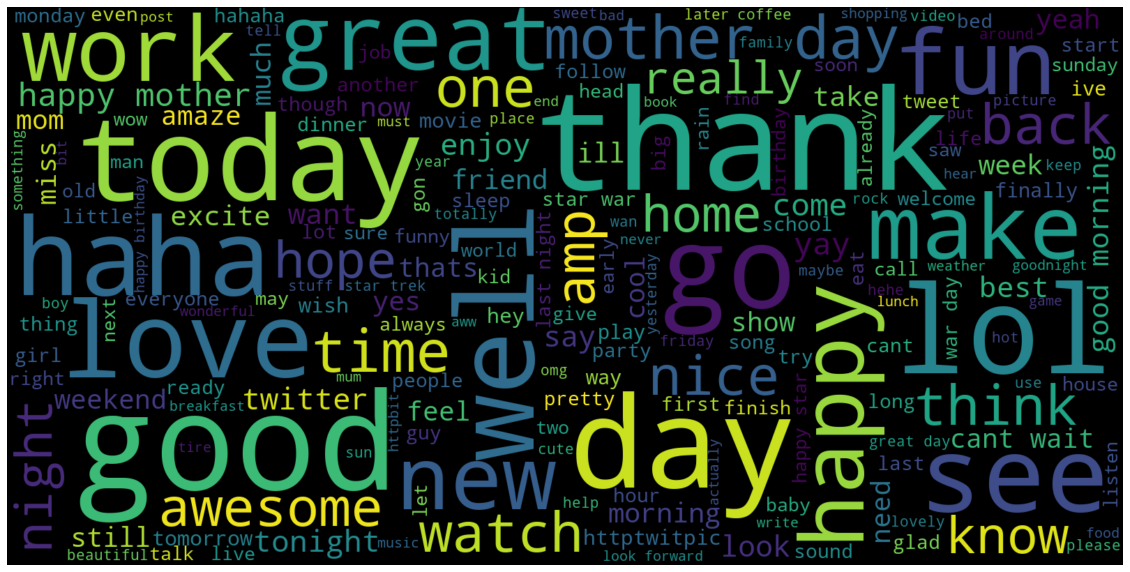

In [20]:
#wordcloud
class_label_0 = df[df['sentiment'] =='happiness']
string_0 = []
for t in class_label_0.content:
    string_0.append(t)
string_0 = pd.Series(string_0).str.cat(sep=' ')
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(string_0)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
labelencoder = LabelEncoder()
df['sentiment'] = labelencoder.fit_transform(df['sentiment'])

In [22]:
x_all = df['content']
y_all = df['sentiment']

In [23]:
x, x_test, y, y_test = train_test_split(x_all, y_all, stratify=y_all, test_size=0.25, random_state=42)

In [24]:
vec = CountVectorizer()
x = vec.fit_transform(x)
x_test = vec.transform(x_test)

In [26]:
clf = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0, n_jobs=-1)

In [27]:
start_time= time.time()
model = clf.fit(x,y)
print("___ %s seconds ---" % (time.time() - start_time))

___ 18.715606927871704 seconds ---


In [28]:
predictions = clf.predict_proba(x_test)

In [32]:
# model.score(x_test, y_test)

In [33]:
predictions

array([[0.03      , 0.        , 0.01      , ..., 0.06      , 0.02      ,
        0.17916667],
       [0.01      , 0.02      , 0.02      , ..., 0.176     , 0.27      ,
        0.15733333],
       [0.        , 0.03      , 0.        , ..., 0.16      , 0.09      ,
        0.23      ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.08      , 0.        ,
        0.14      ],
       [0.        , 0.        , 0.00407332, ..., 0.        , 0.02      ,
        0.00529506],
       [0.        , 0.        , 0.00557175, ..., 0.085     , 0.01      ,
        0.73671985]])

In [34]:
y_classes = predictions.argmax(axis=-1)

In [35]:
y_classes

array([ 8, 11,  8, ...,  8,  5, 12])

In [36]:
cf_matrix = confusion_matrix(y_test, y_classes)
cf_matrix

array([[   0,    0,    0,    0,    0,    2,    1,    3,   11,    1,    3,
           0,    6],
       [   0,    0,    3,    0,    0,    4,    1,    1,   22,    0,    4,
           0,   10],
       [   0,    1,    2,    0,    0,   14,    1,    3,  111,    3,   16,
           0,   56],
       [   0,    0,    0,    2,    1,   33,    3,    5,   87,    1,   12,
           0,   46],
       [   0,    0,    2,    0,    2,   97,    4,   33,  207,    5,   17,
           5,   72],
       [   0,    1,   10,    4,    7,  362,    9,  155,  498,   26,   59,
          10,  161],
       [   0,    1,    2,    0,    1,   10,   22,    8,  146,    2,   36,
           3,  100],
       [   0,    0,    7,    1,    3,  159,    2,  378,  261,    4,   39,
           5,  101],
       [   0,    2,   21,    6,    9,  187,   18,   77, 1309,   20,  117,
          22,  371],
       [   0,    0,    5,    0,    1,   52,    3,   33,  188,   15,   14,
           1,   70],
       [   0,    0,   10,    1,    5,   65,   22, 

In [37]:
y_prdicted_lables = labelencoder.inverse_transform(y_classes)

In [38]:
y_prdicted_lables

array(['neutral', 'surprise', 'neutral', ..., 'neutral', 'happiness',
       'worry'], dtype=object)